In [96]:
# -*- coding: utf-8 -*-
"""
Created on Fri 21 2020
@author: Thiago Pinho
"""

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn import metrics
from sklearn.metrics import accuracy_score
from spacy.lang.pt import Portuguese
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import xlsxwriter
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import string
import pyLDAvis.gensim
from tqdm.notebook import tqdm
from pprint import pprint

In [112]:

class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self


def get_params(self, deep=True):
    return {}


def clean_text(text):
    text = str(text)
    text = text.strip().replace("\n", " ").replace("\r", " ")
    return text


def tokenize_text(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(
            tok.lemma_.strip()
            if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens


def print_n_most_informative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)

def lemmatizer(doc):
    """  This takes in a doc of tokens from the NER and lemmatizes them.  
        Pronouns (like "I" and "you" get lemmatized to "-PRON-",
        so I"m removing those.
    """
    doc = [token.lemma_ for token in doc if token.lemma_ != "-PRON-"]
    doc = u" ".join(doc)
    return nlp.make_doc(doc)


def remove_stopwords(doc):
    """  This will remove stopwords and punctuation. 
        Use token.text to return strings, which we"ll need for Gensim.
    """
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

In [15]:
VECTOR_MODEL_NAME = "pt_core_news_sm"
RELATIVE_PATH_TO_FOLDER = "./assets/datasets/ribon/"
DATA_FILENAME = "Feeds_Label"
parser = Portuguese()
STOPLIST = set(stopwords.words("portuguese")).union(set(["a", "o", "A", "O"]))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]
TARGET_VARIABLE = "LABEL_TRAIN"
TEXT_VARIABLE = "TITLE"
print(STOPLIST)
print(SYMBOLS)

{'mais', 'pela', 'no', 'vocês', 'serei', 'delas', 'esta', 'estas', 'terei', 'numa', 'lhe', 'seria', 'houvessem', 'que', 'tenhamos', 'eram', 'deles', 'estiverem', 'estive', 'na', 'estou', 'num', 'estivermos', 'entre', 'aquelas', 'tu', 'seja', 'dela', 'temos', 'tenham', 'houveram', 'aquela', 'há', 'minhas', 'sejamos', 'tua', 'fora', 'qual', 'tinham', 'até', 'tivéssemos', 'houver', 'aquilo', 'teria', 'são', 'terão', 'estão', 'pelos', 'dos', 'estivera', 'tínhamos', 'O', 'estivesse', 'houvemos', 'das', 'tivéramos', 'uma', 'isto', 'de', 'somos', 'houvéramos', 'sua', 'aquele', 'nem', 'ele', 'fôssemos', 'para', 'estivéssemos', 'houveríamos', 'quem', 'eles', 'em', 'como', 'pelo', 'houvermos', 'tém', 'sem', 'aqueles', 'estejam', 'aos', 'está', 'nosso', 'seremos', 'teremos', 'com', 'o', 'eu', 'vos', 'tivera', 'lhes', 'tem', 'hei', 'a', 'A', 'houverá', 'estejamos', 'teriam', 'nossa', 'houveria', 'tivemos', 'também', 'nós', 'do', 'se', 'esteve', 'suas', 'te', 'for', 'estivéramos', 'havemos', 'houve

In [16]:
"""  load the dataset """
relative_path_file = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + ".csv"
df_ribon_news = pd.read_csv(relative_path_file)
print(df_ribon_news.head())

   id  pick_count                                            content  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               title    Label_Train  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        Animais  
1  Muros da gentileza ajudam desabrigados e famíl...  Solidariedade  
2  20 fotos maravilhosas mostrando a alegria de t...        Familia  
3  13 razões pelas quais crianças são bem mais es...       Criancas  
4  Ex-executiva fala sobre vida sem propósito - I...      Proposito  


In [17]:
"""  Preprocess the dataset names and values """
df_ribon_news.columns = map(lambda x: str(x).upper(), df_ribon_news.columns)
df_ribon_news[TARGET_VARIABLE] = df_ribon_news[TARGET_VARIABLE].str.upper()
""" Converting all labels to lowercase """
print(df_ribon_news.head())

   ID  PICK_COUNT                                            CONTENT  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               TITLE    LABEL_TRAIN  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        ANIMAIS  
1  Muros da gentileza ajudam desabrigados e famíl...  SOLIDARIEDADE  
2  20 fotos maravilhosas mostrando a alegria de t...        FAMILIA  
3  13 razões pelas quais crianças são bem mais es...       CRIANCAS  
4  Ex-executiva fala sobre vida sem propósito - I...      PROPOSITO  


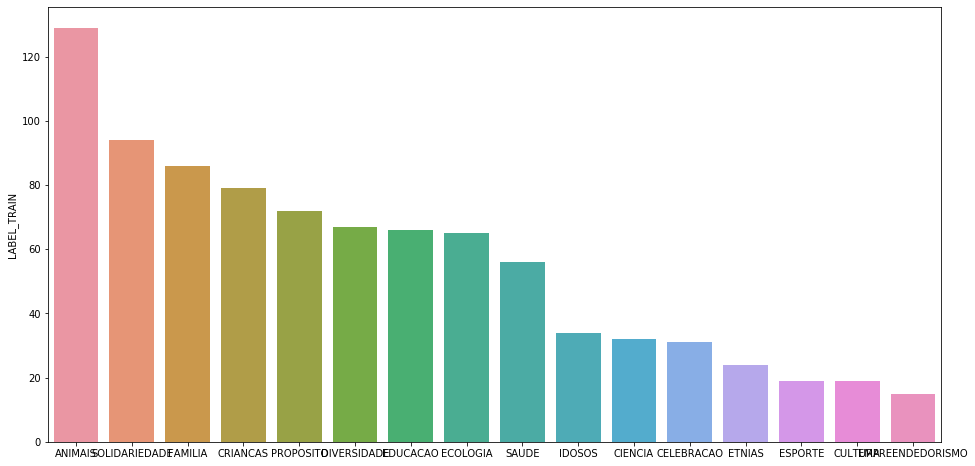

In [18]:
"""  Let"s see how the labels are distributed """
fig = plt.figure(figsize=(16, 8))
sns.barplot(
    x=df_ribon_news[TARGET_VARIABLE].unique(),
    y=df_ribon_news[TARGET_VARIABLE].value_counts())
plt.show()

In [20]:

"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + "_treated.xlsx"

"""  Convert the dataframe to an xlsx file """
df_ribon_news.to_excel(excel_filename)

"""  We then load the data for stability """
df_ribon_news_treated = pd.read_excel(excel_filename, index_col=0)
print(df_ribon_news_treated.head())

   ID  PICK_COUNT                                            CONTENT  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               TITLE    LABEL_TRAIN  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        ANIMAIS  
1  Muros da gentileza ajudam desabrigados e famíl...  SOLIDARIEDADE  
2  20 fotos maravilhosas mostrando a alegria de t...        FAMILIA  
3  13 razões pelas quais crianças são bem mais es...       CRIANCAS  
4  Ex-executiva fala sobre vida sem propósito - I...      PROPOSITO  


In [21]:
for label in df_ribon_news_treated[TARGET_VARIABLE].unique():
    print(
        label + ": ",
        len(df_ribon_news_treated[
            df_ribon_news_treated[TARGET_VARIABLE] == label]))

ANIMAIS:  67
SOLIDARIEDADE:  94
FAMILIA:  19
CRIANCAS:  19
PROPOSITO:  86
DIVERSIDADE:  72
EDUCACAO:  66
ECOLOGIA:  129
SAUDE:  24
IDOSOS:  15
CIENCIA:  31
CELEBRACAO:  56
ETNIAS:  65
ESPORTE:  34
CULTURA:  79
EMPREENDEDORISMO:  32


In [24]:
""" As we have two text variables CONTENT and TITLE.
    we can use both of then to improve predictions
"""
first_pipeline_text_variable = "CONTENT"
second_pipeline_text_variable = "TITLE"

df_first_ribon_news_data = df_ribon_news_treated[
    [first_pipeline_text_variable, TARGET_VARIABLE]]
df_second_ribon_news_data = df_ribon_news_treated[
    [second_pipeline_text_variable, TARGET_VARIABLE]]

"""  Let"s store the data """
excel_first_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_first_data.xlsx"
excel_second_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_second_data.xlsx"

df_first_ribon_news_data.to_excel(excel_first_filename)
df_second_ribon_news_data.to_excel(excel_second_filename)

"""  We then load the data for stability """
df_first_data = pd.read_excel(excel_first_filename, index_col=0)
df_second_data = pd.read_excel(excel_second_filename, index_col=0)
print(df_first_data.head())
print(df_second_data.head())

                                             CONTENT    LABEL_TRAIN
0  A forte ligação dos cães com o ser humano desp...        ANIMAIS
1  Os chamados muros da gentileza estão promovend...  SOLIDARIEDADE
2  Alguns de nós sabem a sorte que é ter um irmão...        FAMILIA
3               Temos muito o que aprender com elas.       CRIANCAS
4  Esqueça o que te disseram sobre a zona de conf...      PROPOSITO
                                               TITLE    LABEL_TRAIN
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        ANIMAIS
1  Muros da gentileza ajudam desabrigados e famíl...  SOLIDARIEDADE
2  20 fotos maravilhosas mostrando a alegria de t...        FAMILIA
3  13 razões pelas quais crianças são bem mais es...       CRIANCAS
4  Ex-executiva fala sobre vida sem propósito - I...      PROPOSITO


In [28]:
"""  Let"s create a train and test sample """
"""  for TITLE -> TRAIN_LABEL analysis """
y_variable = "LABEL_TRAIN"
X_variable = first_pipeline_text_variable
df_X_data = df_first_data[X_variable]
df_y_data = df_first_data[y_variable]

X_train, X_test, y_train, y_test = train_test_split(
    df_X_data.values,
    df_y_data.values,
    test_size=0.33, random_state=42)
print("One sample of the " + X_variable + " column: ", X_train[0])
print("This sample respective " + y_variable + "column: ", y_train[0])
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

One sample of the CONTENT column:  Pelo fim da desnutrição no mundo - ONGs que apoiamos
This sample respective LABEL_TRAINcolumn:  PROPOSITO
Training Data Shape: (594,)
Testing Data Shape: (294,)


In [26]:
vectorizer = CountVectorizer(tokenizer=tokenize_text, ngram_range=(1, 1))
clf = LinearSVC()

pipe = Pipeline(
    [("cleanText", CleanTextTransformer()),
        ("vectorizer", vectorizer), ("clf", clf)])
"""  data """
train1 = X_train.tolist()
labelsTrain1 = y_train.tolist()
test1 = X_test.tolist()
labelsTest1 = y_test.tolist()
"""  train """
pipe.fit(train1, labelsTrain1)
"""  test """
preds = pipe.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")
print_n_most_informative(vectorizer, clf, 10)

print(
    metrics.classification_report(
        labelsTest1,
        preds,
        target_names=df_first_data[y_variable].unique()))

accuracy: 0.40476190476190477
Top 10 features used to predict: 
Class 1 best: 
(-0.1638873359647052, 'nan')
(-0.13657275365055274, 'aprender')
(-0.1154749734468693, 'mãe')
(-0.11206550215408034, 'ribon')
(-0.11176430463091126, 'mundo')
(-0.09185266179534529, 'crianças')
(-0.08344157313541122, 'brasil')
(-0.08055991450147623, 'novembro')
(-0.08011121231515056, 'deveria')
(-0.07928079985219534, 'lugar')
Class 2 best: 
(0.3770705330619924, 'cães')
(0.2986084253135207, 'animais')
(0.2615603983099541, 'elefantes')
(0.2076469637719078, 'pj')
(0.20142246646088863, 'cão')
(0.18909798714482096, 'separados')
(0.18909798714482096, 'lana')
(0.18909798714482096, 'compartilha')
(0.18909798714482096, 'cobertor')
(0.18909798714482096, 'cadelinha')
                  precision    recall  f1-score   support

         ANIMAIS       0.64      0.54      0.58        26
   SOLIDARIEDADE       0.25      0.15      0.19        20
         FAMILIA       0.40      0.17      0.24        12
        CRIANCAS       0.

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
"""  Let"s create a train and test sample
    for TITLE -> TRAIN_LABEL analysis
"""
y_variable = "LABEL_TRAIN"
X_variable = second_pipeline_text_variable
df_X_data = df_second_data[X_variable]
df_y_data = df_second_data[y_variable]

X_train, X_test, y_train, y_test = train_test_split(
    df_X_data.values,
    df_y_data.values,
    test_size=0.33, random_state=42)
print("One sample of the " + X_variable + " column: ", X_train[0])
print("This sample respective " + y_variable + "column: ", y_train[0])
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

vectorizer = CountVectorizer(tokenizer=tokenize_text, ngram_range=(1, 1))
clf = LinearSVC()

pipe = Pipeline(
    [("clean_text", CleanTextTransformer()),
        ("vectorizer", vectorizer), ("clf", clf)])
"""  data """
train1 = X_train.tolist()
labelsTrain1 = y_train.tolist()
test1 = X_test.tolist()
labelsTest1 = y_test.tolist()
"""  train """
pipe.fit(train1, labelsTrain1)
"""  test """
preds = pipe.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")
print_n_most_informative(vectorizer, clf, 10)

print(
    metrics.classification_report(
        labelsTest1,
        preds,
        target_names=df_second_data[y_variable].unique()))

One sample of the TITLE column:  Conheça a PHC
This sample respective LABEL_TRAINcolumn:  PROPOSITO
Training Data Shape: (594,)
Testing Data Shape: (294,)
accuracy: 0.38095238095238093
Top 10 features used to predict: 
Class 1 best: 
(-0.1897695654484011, 'bióloga')
(-0.1635271927769133, 'crianças')
(-0.16040116492707607, 'podem')
(-0.15355994989584512, 'prêmio')
(-0.1485855644994231, 'ganha')
(-0.1413300517294916, 'alimentos')
(-0.13149137651578377, 'designer')
(-0.13069733011134685, 'internacional')
(-0.13069733011134682, 'rodovias')
(-0.1306973301113468, 'brasileira')
Class 2 best: 
(0.8801645795362907, 'animais')
(0.8208041132992558, 'cães')
(0.609589361634002, 'elefantes')
(0.6064772934266579, 'generosidade')
(0.5963571227642993, 'abandonados')
(0.5328490566675717, 'elefanta')
(0.5278138155385432, 'cãozinho')
(0.5004308967226171, 'zoológico')
(0.4936585752672306, 'menos')
(0.4890770406465321, 'cadela')
                  precision    recall  f1-score   support

         ANIMAIS    

In [113]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRegressor

"""  Now we found that which text variable is more descriptive let's decide which model
     have a better perfomance with this kind of data 
"""
y_variable = "LABEL_TRAIN"
X_variable = first_pipeline_text_variable
df_X_data = df_first_data[X_variable]
df_y_data = df_first_data[y_variable]

vectorizer = CountVectorizer(tokenizer=tokenize_text, ngram_range=(1, 1))
tf_transformer = TfidfTransformer(use_idf=True)
clf = CalibratedClassifierCV()

first_pipe = Pipeline(
    [("clean_text", CleanTextTransformer()),
        ("vectorizer", vectorizer),
        ("tfidf", tf_transformer),
        ("clf", clf)])

scores = cross_val_score(first_pipe, df_X_data, df_y_data, cv=5)
print("Mean model scores for first:", scores.mean())

Mean model scores for first: 0.4729702278930997


In [114]:
svm = SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=10, tol=None)

second_pipe = Pipeline(
    [("clean_text", CleanTextTransformer()),
        ("vectorizer", vectorizer),
        ("tfidf", tf_transformer),
        ("svm", svm)])

scores = cross_val_score(second_pipe, df_X_data, df_y_data, cv=5)
print("Mean model scores for first:", scores.mean())

Mean model scores for first: 0.47634101440995363
